### **GPU cehck**

In [21]:
import tensorflow as tf
import tensorflow.keras.backend as K
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')
tf.sysconfig.get_build_info()

OrderedDict([('cpu_compiler',
              '/home/builder/ktietz/aggregate/tensorflow_recipes/ci_cpu/tensorflow-base_1614534878484/_build_env/bin/x86_64-conda_cos6-linux-gnu-gcc'),
             ('cuda_compute_capabilities',
              ['compute_35',
               'compute_52',
               'compute_60',
               'compute_61',
               'compute_70',
               'compute_75']),
             ('cuda_version', '10.1'),
             ('cudnn_version', '7'),
             ('is_cuda_build', True),
             ('is_rocm_build', False)])

## **Module**

In [22]:
from datetime import datetime
import os
import re
import gc
import pickle
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce

from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
import umap.umap_ as umap

# keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

# rpy2
os.environ['R_HOME'] = '/home/km/anaconda3/envs/multiomics/lib/R' # env R invoke
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

!python -m rpy2.situation

rpy2 version:
3.4.5
Python version:
3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /home/km/anaconda3/envs/multiomics/lib/R
    Calling `R RHOME`: /usr/lib/R
    Environment variable R_LIBS_USER: ~/R/x86_64-conda-linux-gnu-library/4.1
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.0.5 (2021-03-31) -- "Shake and Throw"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/home/km/anaconda3/envs/multiomics/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/home/km/anaconda3/envs/multiomics/lib', '/home/km/anaconda3/envs/multiomics/lib/R/lib', '/home/km/anaconda3/envs/multiomics/lib']
  extra_compile_args:
  []
  extra_link_args:
  ['-Wl,--export-dynamic', '-fopenmp', '-Wl,-O2', '-Wl,--sort-common', '-Wl,--as-needed', '-Wl,-z,relro', '-Wl,-z,now

## **UDF**

In [23]:
def cancer_select(cols, cancer_type):
    # phenotype
    phe1 = pd.read_csv("https://gdc-hub.s3.us-east-1.amazonaws.com/download/GDC-PANCAN.basic_phenotype.tsv.gz", sep="\t")
    phe1 = phe1.loc[phe1.program == "TCGA", :].loc[:, ['sample', 'sample_type', 'project_id']].drop_duplicates(['sample'])
    phe1['sample'] =  phe1.apply(lambda x : x['sample'][:-1], axis=1)
    phe2 = pd.read_csv("https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/TCGA_phenotype_denseDataOnlyDownload.tsv.gz", sep="\t")
    ph_join = pd.merge(left = phe2 , right = phe1, how = "left", on = "sample").dropna(subset=['project_id'])
    
    if cancer_type == "PAN" or cancer_type == "PANCAN":
        filterd = ph_join.loc[ph_join['sample_type_y'] == "Primary Tumor", :]
        sample_barcode = filterd["sample"].tolist()
    else:
        filterd = ph_join.loc[(ph_join['sample_type_y'] == "Primary Tumor") & (ph_join['project_id'] == "TCGA-" + cancer_type) , :]
        sample_barcode = filterd["sample"].tolist()
        
    intersect_ = list(set(cols).intersection(sample_barcode))
    
    return intersect_

def non_zero_column(DF):
    sample_cnt = int(len(DF.columns) * 0.2)
    zero_row = dict(DF.isin([0]).sum(axis=1))
    non_remove_feature = list()

    for key, value in zero_row.items():
        if value < sample_cnt:
            non_remove_feature.append(key)
    
    return non_remove_feature

def load_tcga_dataset(pkl_path, raw_path, cancer_type, norm):
    
    if os.path.isfile(pkl_path + "/" + cancer_type + "_omics.pkl"):
        omics = pd.read_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")

        # sep
        rna = pd.read_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")
        mirna = pd.read_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")
        mt = pd.read_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
        # intersect
        venn3_unweighted([set(rna.index), set(mirna.index), set(mt.index)], ('RNA', 'miRNA', 'Methylation'))
        plt.show()
        
    else :
        # RNA gene expression
        col = pd.read_csv(raw_path + "tcga_RSEM_Hugo_norm_count.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)
        df_chunk = pd.read_csv(raw_path + "tcga_RSEM_Hugo_norm_count.gz",
                     sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        rna = pd.concat([chunk for chunk in df_chunk])
        rna = rna[rna.index.isin(non_zero_column(rna))].T
        
        rna.to_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")

        # miRNA expression
        col = pd.read_csv(raw_path + "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)

        df_chunk = pd.read_csv(raw_path + "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz",
                         sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        mirna = pd.concat([chunk for chunk in df_chunk])
        mirna = mirna[mirna.index.isin(non_zero_column(mirna))].T
        
        mirna.to_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")

        # methylation
        col = pd.read_csv(raw_path + "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)

        df_chunk = pd.read_csv(raw_path + "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena.gz",
                         sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        mt = pd.concat([chunk for chunk in df_chunk])

        mt_map = pd.read_csv(raw_path + "probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy", sep="\t")

        mt_join = pd.merge(mt, mt_map, how = "left", left_on = "sample", right_on = "#id")\
                 .drop(['chrom', 'chromStart', 'chromEnd', 'strand', '#id'], axis=1)
        mt_join = mt_join[mt_join.gene != "."]
        mt_join.dropna(subset = ["gene"], inplace=True)

        # gene mean 
        mt_join_gene_filter = mt_join.groupby(['gene']).mean()
        mt_join_gene_filter = mt_join_gene_filter[mt_join_gene_filter.index.isin(non_zero_column(mt_join_gene_filter))].T
        
        mt_join_gene_filter.to_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
        # intersect
        venn3_unweighted([set(rna.index), set(mirna.index), set(mt_join_gene_filter.index)], ('RNA', 'miRNA', 'Methylation'))
        plt.show()
        
        # set same column for merge
        rna['sample'] = rna.index
        mirna['sample'] = mirna.index
        mt_join_gene_filter['sample'] = mt_join_gene_filter.index

        # data join
        merge_list = [rna, mirna, mt_join_gene_filter]
        omics = reduce(lambda left, right : pd.merge(left, right, on = "sample"), merge_list)
        omics.set_index('sample', inplace=True)

        # pickle save
        omics.to_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")
    
    # set index
    omics_index = omics.index.to_list()
#     omics = omics.drop(['sample'], axis = 1)
    
    # normalization
    if norm:
        scalerX = StandardScaler()
        scalerX.fit(omics)
        omics_scale = scalerX.transform(omics)
    
    # missing impute
    imputer = KNNImputer(n_neighbors=10)
    omics_impute = imputer.fit_transform(omics_scale)

    omics = pd.DataFrame(omics_impute, columns=omics.columns)
    omics.index = omics_index

    return omics

def root_mean_squared_log_error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

def make_Tensorboard_dir(dir_name):
    root_logdir = os.path.join(os.curdir, dir_name) 
    sub_dir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
    return os.path.join(root_logdir, sub_dir_name)


def createFolder(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print ('Folder already exists. ' +  path)

## **Preprocessing**

### **File Path**

In [24]:
os.getcwd()

'/home/km/gitworking/Multi-omics-intergration/src'

In [50]:
CANCER_TYPE = "LIHC"
RAW_file_path = "/home/km/gitworking/Multi-omics-intergration/RAW_DATA/"
PKL_file_path = "/home/km/gitworking/Multi-omics-intergration/pkl/"
MODEL_path = "/home/km/gitworking/Multi-omics-intergration/models/"
TENSORBOARD_PATH = '/home/km/gitworking/Multi-omics-intergration/log'
GROUP_PHTH = '/home/km/gitworking/Multi-omics-intergration/group/'

* **Data-Load**

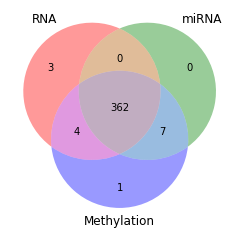

In [26]:
omics = load_tcga_dataset(pkl_path=PKL_file_path, raw_path=RAW_file_path, cancer_type=CANCER_TYPE, norm=True)

In [27]:
X_train, X_test = train_test_split(omics, test_size = .2, random_state = 21, shuffle=True)

## **Auto-Encoder**

* **end-to-end**

In [28]:
tf.keras.backend.clear_session()

inputs_dim = X_train.shape[1]
encoder = Input(shape = (inputs_dim, ))
e = Dense(1000, activation = "relu")(encoder)
# e = Dense(256, activation = "relu")(e)
e = Dense(500, activation = "relu")(e)

## bottleneck layer
n_bottleneck = 100

## defining it with a name to extract it later
bottleneck_layer = "bottleneck_layer"

# can also be defined with an activation function, relu for instance
bottleneck = Dense(n_bottleneck, name = bottleneck_layer)(e)

## define the decoder (in reverse)
decoder = Dense(500, activation = "relu")(bottleneck)
# decoder = Dense(256, activation = "relu")(decoder)
decoder = Dense(1000, activation = "relu")(decoder)

## output layer
output = Dense(inputs_dim)(decoder)

## model
model = Model(inputs = encoder, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 58419)]           0         
_________________________________________________________________
dense (Dense)                (None, 1000)              58420000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
bottleneck_layer (Dense)     (None, 100)               50100     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dense_4 (Dense)              (None, 58419)             584774

* **Encoder for Latent Vector**

In [29]:
encoder = Model(inputs = model.input, outputs = bottleneck)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 58419)]           0         
_________________________________________________________________
dense (Dense)                (None, 1000)              58420000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
bottleneck_layer (Dense)     (None, 100)               50100     
Total params: 58,970,600
Trainable params: 58,970,600
Non-trainable params: 0
_________________________________________________________________


* **Model compile & Fit**

In [30]:
# callback function
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
TB_log_dir = make_Tensorboard_dir(TENSORBOARD_PATH)
TensorB = tf.keras.callbacks.TensorBoard(log_dir = TB_log_dir)

# compile & fit
model.compile(loss = "mean_squared_error",
              optimizer = "adam")
history = model.fit(
    X_train,
    X_train,
    batch_size = 128,
    epochs = 30,
    verbose = 0,
    validation_data = (X_test, X_test),
    callbacks=[TensorB]
)
file_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
model.save(MODEL_path + "AE_" + file_name)

2022-01-11 16:14:46.610578: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-01-11 16:14:46.610609: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-01-11 16:14:46.610763: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-01-11 16:14:46.610787: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-01-11 16:14:47.854459: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-01-11 16:14:47.854562: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-01-11 16:14:47.854733: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

INFO:tensorflow:Assets written to: /home/km/gitworking/Multi-omics-intergration/models/AE_20220111-161458/assets


## **Feature Selection**

In [31]:
omic_encoded = pd.DataFrame(encoder.predict(omics))
column_name = ["Feature" + str(index) for index in range(1, len(omic_encoded.columns) + 1)]
omic_encoded.columns = column_name

omic_encoded['sample'] = omics.index.to_list()
omic_encoded.set_index('sample', inplace=True)

* **sample phenotype**

In [32]:
pheno = pd.read_csv("https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp", 
                    sep = "\t", usecols=['sample', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time'])

# pd.merge(left, right, how, on, left_on, right_on, left_index, right_index)
omic_encoded_pheno = pd.merge(left=omic_encoded, right=pheno, how="inner", on="sample")
omic_encoded_pheno.set_index('sample', inplace=True)

* **Invoke R - log rank test**

In [33]:
# pandas DF to R DF
with localconverter(ro.default_converter + pandas2ri.converter):
    r_from_pd_df = ro.conversion.py2rpy(omic_encoded_pheno)

# R UDF invoke
r = ro.r
r['source']('r-function.R')
log_rank_test_r = ro.globalenv['log_rank_test']
log_rank_test_feature = log_rank_test_r(r_from_pd_df)

# R DF to pandas DF
with localconverter(ro.default_converter + pandas2ri.converter):
    log_rank_test = ro.conversion.rpy2py(log_rank_test_feature)

feature_log = log_rank_test['Features'].to_list()

omic_encoded_fc = omic_encoded[feature_log]

## **Sample Clustering**

In [34]:
# pandas DF to R DF
with localconverter(ro.default_converter + pandas2ri.converter):
    omic_encoded_fc_r = ro.conversion.py2rpy(omic_encoded_fc)

r = ro.r
r['source']('r-function.R')
nb_cluster_test = ro.globalenv['nb_cluster_test']
nb_cluster_test_feature = nb_cluster_test(omic_encoded_fc_r)

# R DF to pandas DF
with localconverter(ro.default_converter + pandas2ri.converter):
    omic_encoded_fc_r = ro.conversion.rpy2py(nb_cluster_test_feature)

******************************************************************* 
* Among all indices:                                                
* 7 proposed 2 as the best number of clusters 
* 8 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 1 proposed 5 as the best number of clusters 
* 1 proposed 6 as the best number of clusters 
* 2 proposed 7 as the best number of clusters 
* 3 proposed 9 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  3 
 
 
******************************************************************* 


* **K-Mean Clustering**

In [45]:
kmeans = KMeans(n_clusters = 2, random_state = 31, max_iter = 1000).fit_predict(omic_encoded_fc)
ae_groups = pd.DataFrame(kmeans, columns = ['group'])
ae_groups['sample'] = omic_encoded_fc.index.to_list()
ae_groups.set_index('sample', inplace=True)

In [51]:
ae_groups.to_csv(GROUP_PHTH + CANCER_TYPE + "_GROUP_" + time_stamp + ".txt", sep="\t")